In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import numpy.linalg as linalg

In [16]:
#must be greater than 0
startR=-10
endR=10
N=10000
sites=N+1
deltaX=np.abs(startR-endR)/N
eps=1
n=1
a=1

In [17]:
def electronDensity(r, a):
    return (1/(np.pi*a**3))*(np.exp(-2*r/a)) if r>0 else (1/(np.pi*a**3))*(np.exp(2*r/a))
    
def linearFunction(r, n):
    return 1/(deltaX) *(r-n)+1 if r<n else -1/(deltaX) *(r-n)+1
    
def integrand(r, eps, n):
    return (1/eps)*electronDensity(r,a)*linearFunction(r, n)*r**2

def getIntegral(a_1, a_2, eps, n):
    return integrate.quad(integrand, a_1, a_2, args=(eps, n))[0]

def v(r):
    return (1/(4*np.pi*eps*a**2))*(a**2/r-(a**2/r-a)*np.exp(-2*r/a)) if r>0 else (1/(4*np.pi*eps))*(-a**2/r-(-a**2/r-a)*np.exp(2*r/a))

In [18]:

#uniform
def constructResultVector():
    theList=[getIntegral(startR+(i-1)*deltaX, startR+(i+1)*deltaX, eps, startR+i*deltaX) for i in range(1,sites-1)];
    return np.array(theList);

def mk(i):
    return ((startR+deltaX*i)**3-(startR+deltaX*(i-1))**3)/(3*deltaX**2)

def boundary_condition(r):
    if(0<=r and r<endR/2):
        return 3/(4*np.pi*a*eps)
    return (1/(4*np.pi*eps))*1/np.abs(r)

def addBoundaryConditions(b):
    b[0]+=boundary_condition(startR)*mk(1)
    b[b.size-1]+=boundary_condition(endR)*mk(N)
    return b


In [19]:
def constructMatrix():
    temp=np.zeros((sites, sites));
    for i in range(sites-1):
        if(i>0):
            temp[i, i-1]=-mk(i)
        if(i>=0):
            temp[i, i]=mk(i+1)+mk(i)
        if(i+1<sites):
            temp[i, i+1]=-mk(i+1)
    temp=np.delete(temp, [0, sites-1], axis=1)
    temp=np.delete(temp, [0, sites-1], axis=0)
    return temp

In [20]:
#func gives grid size at each point
def generateUniformGrid(N):
    delX=(endR-startR)/N
    return [(startR+i*delX,startR+(i+1)*delX) for i in range(N)]

def riemannEst(a_1, a_2, func):
    return func((a_2-a_1)/2+a_1,a)*(a_2-a_1)

def adaptivelySubdivide(l, func, eps,n,maxIt):
    absError=np.abs(riemannEst(l[0], l[1], func)-(riemannEst(l[0], (l[1]-l[0])/2+l[0], func)+riemannEst((l[1]-l[0])/2+l[0], l[1],func)))
    relError=absError/(riemannEst(l[0], l[1], func))
    #print(relError)
    if(relError<eps or n>maxIt):
        return np.array([l])
    else:
        left=(l[0], (l[1]-l[0])/2+l[0])
        right=((l[1]-l[0])/2+l[0], l[1])
        temp=(np.concatenate((adaptivelySubdivide(left, func, eps, n+1,maxIt),adaptivelySubdivide(right, func, eps,n+1,maxIt))))
        return temp
    
#adaptively subdivided to func
def generateListOfAdaptiveGridCoords(N, func, eps, maxIt):
    uni=generateUniformGrid(N)
    newList=[];
    for i in range(len(uni)):
        #adaptively subdivide returns a list
        temp=adaptivelySubdivide(uni[i], func, eps, 0, maxIt);
        for x in temp:
            newList.append(x)
    return np.array(newList,dtype=object)

In [21]:
temp=generateListOfAdaptiveGridCoords(10, electronDensity, 1e-4, 5)

In [22]:
len(temp)

640

In [23]:
b=constructResultVector()
b=addBoundaryConditions(b)

In [24]:
np.shape(b)

(9999,)

In [25]:
M=constructMatrix()

In [26]:
np.shape(M)

(9999, 9999)

In [27]:
sols=linalg.solve(M, b)

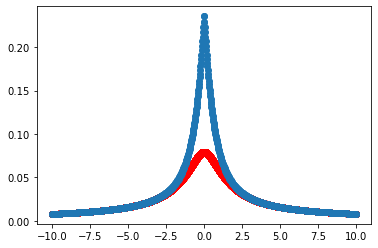

In [28]:
x1=[startR+i*deltaX for i in range(b.size)]
plt.scatter(x1,sols,c="red")
x = np.linspace(startR,endR,1000)
y=[v(r) for r in x]
plt.scatter(x, y)

In [29]:
3/(4*np.pi*a*eps)

0.238732414637843

In [30]:
sols

array([0.00795934, 0.00796093, 0.00796252, ..., 0.00796252, 0.00796093,
       0.00795934])

In [31]:
y[np.shape(y)[0]-1]

0.007957747302214022

In [32]:
np.shape(y)[0]

1000

In [33]:
boundary_condition(startR)

0.007957747154594767

In [34]:
boundary_condition(endR)

0.007957747154594767